Deep Learning
=============

Assignment 5
------------

The goal of this assignment is to train a Word2Vec skip-gram model over [Text8](http://mattmahoney.net/dc/textdata) data.

In [1]:
# These are all the modules we'll be using later. Make sure you can import them
# before proceeding further.
%matplotlib inline
from __future__ import print_function
import collections
import math
import numpy as np
import os
import random
import tensorflow as tf
import zipfile
from matplotlib import pylab
from six.moves import range
from six.moves.urllib.request import urlretrieve
from sklearn.manifold import TSNE

Download the data from the source website if necessary.

In [2]:
url = 'http://mattmahoney.net/dc/'

def maybe_download(filename, expected_bytes):
  """Download a file if not present, and make sure it's the right size."""
  if not os.path.exists(filename):
    filename, _ = urlretrieve(url + filename, filename)
  statinfo = os.stat(filename)
  if statinfo.st_size == expected_bytes:
    print('Found and verified %s' % filename)
  else:
    print(statinfo.st_size)
    raise Exception(
      'Failed to verify ' + filename + '. Can you get to it with a browser?')
  return filename

filename = maybe_download('text8.zip', 31344016)

Found and verified text8.zip


Read the data into a string.

In [3]:
filename = maybe_download('text8.zip', 31344016)
def read_data(filename):
  """Extract the first file enclosed in a zip file as a list of words"""
  with zipfile.ZipFile(filename) as f:
    data = tf.compat.as_str(f.read(f.namelist()[0])).split()
  return data
  
words = read_data(filename)
print('Data size %d' % len(words))

Found and verified text8.zip
Data size 17005207


Build the dictionary and replace rare words with UNK token.

In [4]:
vocabulary_size = 50000

def build_dataset(words):
  count = [['UNK', -1]]
  count.extend(collections.Counter(words).most_common(vocabulary_size - 1))
  #print(count[:10])
  dictionary = dict()
  for word, _ in count:
    dictionary[word] = len(dictionary)
  #print(dictionary)
  data = list()
  unk_count = 0
  for word in words:
    if word in dictionary:
      index = dictionary[word]
    else:
      index = 0  # dictionary['UNK']
      unk_count = unk_count + 1
    data.append(index)
  count[0][1] = unk_count
  #print(count[:15])
  reverse_dictionary = dict(zip(dictionary.values(), dictionary.keys())) 
  return data, count, dictionary, reverse_dictionary

data, count, dictionary, reverse_dictionary = build_dataset(words)
print('Most common words (+UNK)', count[:5])
print('Sample data', data[:10])
#print("dict",dictionary)
#print("revdict",reverse_dictionary)
del words  # Hint to reduce memory.

Most common words (+UNK) [['UNK', 418391], ('the', 1061396), ('of', 593677), ('and', 416629), ('one', 411764)]
Sample data [5234, 3081, 12, 6, 195, 2, 3134, 46, 59, 156]


- dictionary: takes a word and gives its ranking by freq
- reverse dict: takes a ranking by freq and gives the word
- count: array of each word and the freq of the word in descending order (with UNK at pos 0)
- data: array of all text (ordered to make sense as sentences) with numeric values for each word that map the word using reverse_dict i.e. represent the frequency of the word

Function to generate a training batch for the skip-gram model.

In [5]:
data_index = 0

def generate_batch(batch_size, num_skips, skip_window):
  global data_index
  assert batch_size % num_skips == 0
  assert num_skips <= 2 * skip_window
  batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  for i in range(batch_size // num_skips):
    target = skip_window  # target label at the center of the buffer
    targets_to_avoid = [ skip_window ]
    for j in range(num_skips):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      batch[i * num_skips + j] = buffer[skip_window]
      labels[i * num_skips + j, 0] = buffer[target]
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:8]])

for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first']

with num_skips = 2 and skip_window = 1:
    batch: ['originated', 'originated', 'as', 'as', 'a', 'a', 'term', 'term']
    labels: ['as', 'anarchism', 'originated', 'a', 'as', 'term', 'of', 'a']

with num_skips = 4 and skip_window = 2:
    batch: ['as', 'as', 'as', 'as', 'a', 'a', 'a', 'a']
    labels: ['anarchism', 'term', 'a', 'originated', 'term', 'originated', 'of', 'as']


- this function generates a list that is size: batch_size.
- this list features an array that loops through all words in data num_skip times starting at the skip_window'th word (i.e. if skip window = 2 it will be the third word as array starts at pos 0)
- each word will be repeated num_skip times
- the corrosponding entry in the labels array is a random sample of skip_window words taken from a window of size num_window on each side of the word in data.
- to get every word in the skip_window window num_skip has to be equal to skip_wondow*2
- ? each new batch will pick up where the last batch ended?
- 17005207 words in data (print(len(data))) which means that data is loooped through fully after 132 853.18 batches of size 128

In [6]:
print(len(data))

17005207


Train a skip-gram model.

In [7]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
skip_window = 1 # How many words to consider left and right.
num_skips = 2 # How many times to reuse an input to generate a label.
# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))
  #similarity2 = tf.matmul(embeddings,tf.transpose(normalized_embeddings))

In [8]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_batch(
      batch_size, num_skips, skip_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings = normalized_embeddings.eval()

Initialized
Average loss at step 0: 8.315219
Nearest to most: refine, arbor, encouragement, cohort, fistful, realistic, essenes, fredrik,
Nearest to other: adequacy, yelled, vonnegut, sergei, livres, predicament, conrad, archimedean,
Nearest to up: solos, cal, commitments, unfolding, healer, litovsk, saxophone, exponents,
Nearest to some: mss, raceway, marguerite, percentage, temair, crowned, arabian, hovering,
Nearest to was: slavonia, cm, langford, wounding, plight, storytellers, bretton, mediterranean,
Nearest to known: marangella, transmission, flaherty, swnt, motto, sul, wakefulness, contrastive,
Nearest to had: grrm, fridays, dries, cimmerian, darwinian, ignorance, milieu, miscellany,
Nearest to often: purr, breads, bellevue, cryoprotectant, montenegro, documentation, incoming, rourke,
Nearest to who: diger, conservatism, hellman, htm, cumulative, embryogenesis, flaw, pesach,
Nearest to are: stepson, dissension, theorised, lovell, glen, establishments, aristotle, scoreless,
Neare

Average loss at step 52000: 3.438816
Average loss at step 54000: 3.431738
Average loss at step 56000: 3.434072
Average loss at step 58000: 3.404644
Average loss at step 60000: 3.397065
Nearest to most: more, many, some, use, less, madly, nac, deeps,
Nearest to other: different, various, many, including, these, uncreated, those, more,
Nearest to up: out, them, him, off, down, hepburn, together, uga,
Nearest to some: many, several, these, any, both, those, certain, each,
Nearest to was: is, had, became, has, were, although, be, becomes,
Nearest to known: used, such, well, cfcs, referred, available, chavez, settings,
Nearest to had: has, have, was, having, were, subsequently, yet, successfully,
Nearest to often: generally, sometimes, usually, also, commonly, now, frequently, still,
Nearest to who: often, never, which, still, he, she, truffaut, also,
Nearest to are: were, is, have, include, steroids, although, these, be,
Nearest to more: less, most, very, rather, greater, larger, too, bett

In [9]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings[1:num_points+1, :])

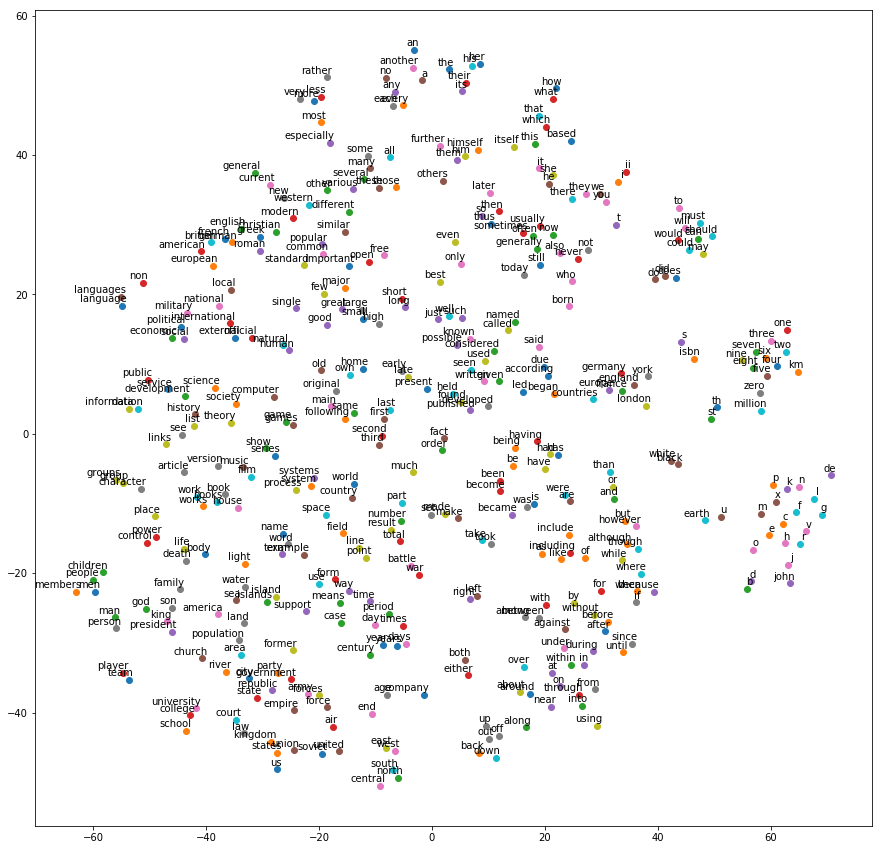

In [10]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)

In [42]:
#print("kittens", dictionary["kittens"])
kitten = final_embeddings[dictionary["kitten"]]
dog = final_embeddings[dictionary["dog"]]
cat = final_embeddings[dictionary["cat"]]
dogs = final_embeddings[dictionary["dogs"]]
cats = final_embeddings[dictionary["cats"]]
puppy = final_embeddings[dictionary["puppy"]]
print("kitten-cat+dog",np.sum(kitten-cat+dog))
print("puppy",np.sum(puppy))
print("kitten-cat+dog-puppy",np.sum(kitten-cat+dog-puppy))
print("cat-cats-dog+dogs: ",np.sum(cat-cats-dogs+dog))

dog_calc = puppy-kitten+cat
#print(dog_calc.shape)
dog_calc2 = np.matmul(final_embeddings,dog_calc)
nearest_dog = dog_calc2.argsort()[0:5]
for i in range(0,5):
    print("output no.%i -hopefully dog:"%i,reverse_dictionary[nearest_dog[i]])
    

#print(type(final_embeddings))
#temp = np.ndarray(normalized_embeddings)
#t0 = time()
#distances = np.matmul(final_embeddings,np.transpose(final_embeddings))
#print("multiplied a 500000x128")
#print(distances.shapes)


kitten-cat+dog -1.70687
puppy -1.24342
kitten-cat+dog-puppy -0.463455
cat-cats-dog+dogs:  2.23426
output no.0 -hopefully dog: kitten
output no.1 -hopefully dog: inconspicuous
output no.2 -hopefully dog: stick
output no.3 -hopefully dog: gemstones
output no.4 -hopefully dog: heb


---

Problem
-------

An alternative to skip-gram is another Word2Vec model called [CBOW](http://arxiv.org/abs/1301.3781) (Continuous Bag of Words). In the CBOW model, instead of predicting a context word from a word vector, you predict a word from the sum of all the word vectors in its context. Implement and evaluate a CBOW model trained on the text8 dataset.

---

I should be able to just switch around batch and labels??? Maybe I need to order by lables? nah

In [43]:
data_index = 0

#def generate_batch(batch_size, num_skips, skip_window):
def generate_cbow_batch(batch_size, context_window):
  global data_index
  #assert batch_size % num_skips == 0
  #assert num_skips <= 2 * skip_window
  #batch = np.ndarray(shape=(batch_size), dtype=np.int32)
  batch = np.ndarray(shape=(batch_size,context_window*2), dtype=np.int32)
  labels = np.ndarray(shape=(batch_size, 1), dtype=np.int32)
  #span = 2 * skip_window + 1 # [ skip_window target skip_window ]
  span = 2*context_window+1
  buffer = collections.deque(maxlen=span)
  for _ in range(span):
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  #for i in range(batch_size // num_skips):
  for i in range(batch_size):
    #target = skip_window  # target label at the center of the buffer
    target = context_window
    #targets_to_avoid = [ skip_window ]
    targets_to_avoid = [ context_window ]
    #for j in range(num_skips):
    labels[i] = buffer[context_window] # setting the label to the output word
    for j in range(2*context_window):
      while target in targets_to_avoid:
        target = random.randint(0, span - 1)
      targets_to_avoid.append(target)
      #batch[i * num_skips + j] = buffer[skip_window]
      #labels[i * num_skips + j, 0] = buffer[target]
      batch[i][j] = buffer[target]
    
    buffer.append(data[data_index])
    data_index = (data_index + 1) % len(data)
  return batch, labels

print('data:', [reverse_dictionary[di] for di in data[:10]])

'''
for num_skips, skip_window in [(2, 1), (4, 2)]:
    data_index = 0
    batch, labels = generate_batch(batch_size=8, num_skips=num_skips, skip_window=skip_window)
    print('\nwith num_skips = %d and skip_window = %d:' % (num_skips, skip_window))
    print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])
'''
for context_window in (1, 2):
    data_index = 0
    batch, labels = generate_cbow_batch(batch_size=8, context_window=context_window)
    print('\nwith context_window = %d:' % (context_window))
    for j in range(0,2*context_window):
      print('    batch%i:'%j, [reverse_dictionary[bi] for bi in batch[:,j]])
      #print('    batch:', [reverse_dictionary[bi] for bi in batch])
    print('    labels:', [reverse_dictionary[li] for li in labels.reshape(8)])

data: ['anarchism', 'originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']

with context_window = 1:
    batch0: ['as', 'a', 'as', 'a', 'abuse', 'first', 'abuse', 'first']
    batch1: ['anarchism', 'originated', 'term', 'of', 'term', 'of', 'used', 'against']
    labels: ['originated', 'as', 'a', 'term', 'of', 'abuse', 'first', 'used']

with context_window = 2:
    batch0: ['a', 'as', 'of', 'a', 'first', 'abuse', 'early', 'used']
    batch1: ['originated', 'originated', 'as', 'term', 'term', 'against', 'against', 'working']
    batch2: ['term', 'term', 'a', 'first', 'used', 'used', 'first', 'early']
    batch3: ['anarchism', 'of', 'abuse', 'abuse', 'of', 'of', 'abuse', 'first']
    labels: ['as', 'a', 'term', 'of', 'abuse', 'first', 'used', 'against']


In [44]:
#data_index = 0
#batch, labels = generate_cbow_batch(batch_size=8, context_window=1)
#for i in range(8):
#    print(batch[i, 0], reverse_dictionary[batch[i, 0]],
#          batch[i, 1], reverse_dictionary[batch[i, 1]],
#          '->', labels[i, 0], reverse_dictionary[labels[i, 0]])

In [45]:
batch_size = 128
embedding_size = 128 # Dimension of the embedding vector.
context_window = 1

#skip_window = 1 # How many words to consider left and right.
#num_skips = 2 # How many times to reuse an input to generate a label.

# We pick a random validation set to sample nearest neighbors. here we limit the
# validation samples to the words that have a low numeric ID, which by
# construction are also the most frequent. 
valid_size = 16 # Random set of words to evaluate similarity on.
valid_window = 100 # Only pick dev samples in the head of the distribution.
valid_examples = np.array(random.sample(range(valid_window), valid_size))
num_sampled = 64 # Number of negative examples to sample.

graph = tf.Graph()

with graph.as_default(), tf.device('/cpu:0'):

  # Input data.
  train_dataset = tf.placeholder(tf.int32, shape=[batch_size,context_window*2])
  train_labels = tf.placeholder(tf.int32, shape=[batch_size, 1])
  valid_dataset = tf.constant(valid_examples, dtype=tf.int32)
  
  # Variables.
  embeddings = tf.Variable(
    tf.random_uniform([vocabulary_size, embedding_size], -1.0, 1.0))
  softmax_weights = tf.Variable(
    tf.truncated_normal([vocabulary_size, embedding_size],
                         stddev=1.0 / math.sqrt(embedding_size)))
  softmax_biases = tf.Variable(tf.zeros([vocabulary_size]))
  
  # Model.
  # Look up embeddings for inputs.
  embed = tf.nn.embedding_lookup(embeddings, train_dataset)
  embed_context =tf.reduce_mean(embed,1)
  # Compute the softmax loss, using a sample of the negative labels each time.
  loss = tf.reduce_mean(
    tf.nn.sampled_softmax_loss(weights=softmax_weights, biases=softmax_biases, inputs=embed_context,
                               labels=train_labels, num_sampled=num_sampled, num_classes=vocabulary_size))

  # Optimizer.
  # Note: The optimizer will optimize the softmax_weights AND the embeddings.
  # This is because the embeddings are defined as a variable quantity and the
  # optimizer's `minimize` method will by default modify all variable quantities 
  # that contribute to the tensor it is passed.
  # See docs on `tf.train.Optimizer.minimize()` for more details.
  optimizer = tf.train.AdagradOptimizer(1.0).minimize(loss)
  
  # Compute the similarity between minibatch examples and all embeddings.
  # We use the cosine distance:
  norm = tf.sqrt(tf.reduce_sum(tf.square(embeddings), 1, keep_dims=True))
  normalized_embeddings = embeddings / norm
  valid_embeddings = tf.nn.embedding_lookup(
    normalized_embeddings, valid_dataset)
  similarity = tf.matmul(valid_embeddings, tf.transpose(normalized_embeddings))

In [46]:
num_steps = 100001

with tf.Session(graph=graph) as session:
  tf.global_variables_initializer().run()
  print('Initialized')
  average_loss = 0
  for step in range(num_steps):
    batch_data, batch_labels = generate_cbow_batch(
      batch_size, context_window)
    feed_dict = {train_dataset : batch_data, train_labels : batch_labels}
    _, l = session.run([optimizer, loss], feed_dict=feed_dict)
    average_loss += l
    if step % 2000 == 0:
      if step > 0:
        average_loss = average_loss / 2000
      # The average loss is an estimate of the loss over the last 2000 batches.
      print('Average loss at step %d: %f' % (step, average_loss))
      average_loss = 0
    # note that this is expensive (~20% slowdown if computed every 500 steps)
    if step % 10000 == 0:
      sim = similarity.eval()
      for i in range(valid_size):
        valid_word = reverse_dictionary[valid_examples[i]]
        top_k = 8 # number of nearest neighbors
        nearest = (-sim[i, :]).argsort()[1:top_k+1]
        log = 'Nearest to %s:' % valid_word
        for k in range(top_k):
          close_word = reverse_dictionary[nearest[k]]
          log = '%s %s,' % (log, close_word)
        print(log)
  final_embeddings2 = normalized_embeddings.eval()

Initialized
Average loss at step 0: 7.821512
Nearest to many: encodes, melilla, shag, ancestral, perestroika, progenitor, krzy, suffers,
Nearest to for: conscription, tuck, dram, tutelage, milner, dermal, meer, methodus,
Nearest to after: contraceptives, deeds, meeting, sligo, cried, cunha, antarctic, produced,
Nearest to during: pledging, depicted, menezes, bp, ceding, fabius, catastrophism, rump,
Nearest to the: chiapas, ltspkr, cosmogony, turntable, jafar, solf, nave, delle,
Nearest to state: jupiter, francisco, hellas, thailand, foundered, dolmen, maneuverable, secret,
Nearest to most: marion, fluoride, modi, invertebrate, regalia, dien, philology, achievable,
Nearest to some: polyglot, heterochromatin, reaction, parrish, activating, ava, empowered, gendarmerie,
Nearest to however: hou, mesogens, sixtus, interglacial, enlai, genetical, has, deciphered,
Nearest to at: capitolina, beg, lensing, misfortunes, uzi, lectionis, tory, assassinations,
Nearest to this: blackadder, crb, subst

Average loss at step 52000: 2.882249
Average loss at step 54000: 2.862422
Average loss at step 56000: 2.861565
Average loss at step 58000: 2.766550
Average loss at step 60000: 2.824060
Nearest to many: some, several, various, these, most, all, those, few,
Nearest to for: meteora, grievance, without, amongst, milner, crazed, unlike, ultrasonic,
Nearest to after: before, during, when, while, following, ancillary, unceasing, without,
Nearest to during: in, after, throughout, through, when, within, from, before,
Nearest to the: its, their, ltspkr, your, our, his, this, a,
Nearest to state: government, city, thailand, rota, indiana, hellas, army, terrorism,
Nearest to most: more, many, some, less, ae, suspending, particularly, plotinus,
Nearest to some: many, several, any, these, all, certain, most, various,
Nearest to however: but, although, though, that, herbrand, especially, where, regained,
Nearest to at: in, during, on, globin, sclerosis, disaccharide, goetz, lensing,
Nearest to this: 

In [47]:
num_points = 400

tsne = TSNE(perplexity=30, n_components=2, init='pca', n_iter=5000, method='exact')
two_d_embeddings = tsne.fit_transform(final_embeddings2[1:num_points+1, :])

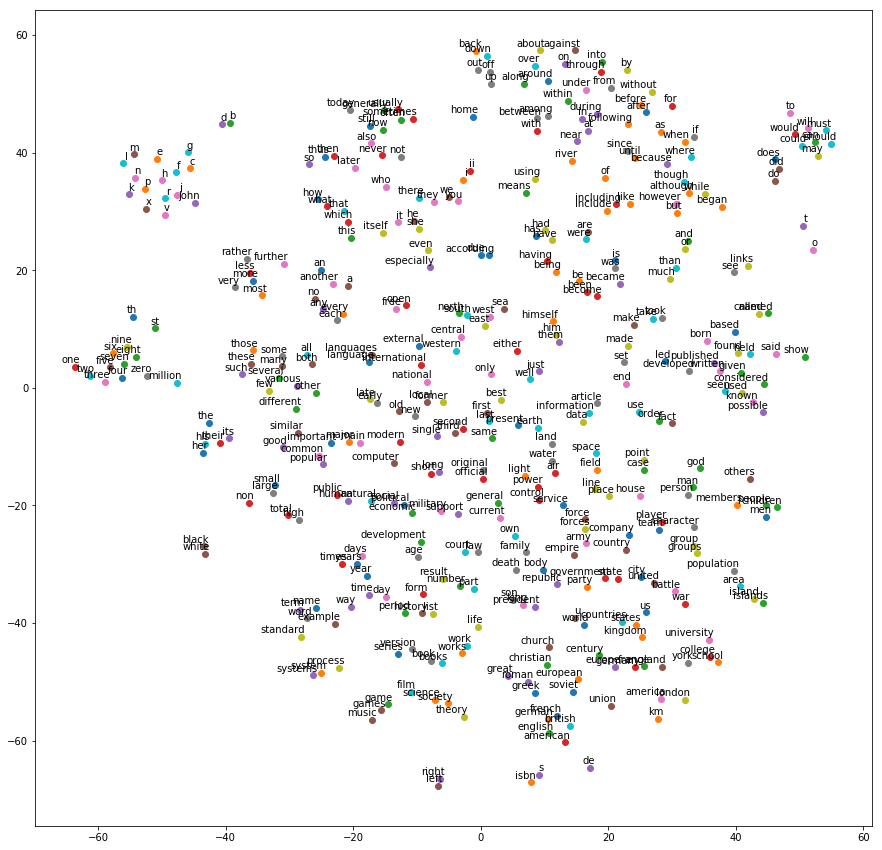

In [48]:
def plot(embeddings, labels):
  assert embeddings.shape[0] >= len(labels), 'More labels than embeddings'
  pylab.figure(figsize=(15,15))  # in inches
  for i, label in enumerate(labels):
    x, y = embeddings[i,:]
    pylab.scatter(x, y)
    pylab.annotate(label, xy=(x, y), xytext=(5, 2), textcoords='offset points',
                   ha='right', va='bottom')
  pylab.show()

words = [reverse_dictionary[i] for i in range(1, num_points+1)]
plot(two_d_embeddings, words)